# Harmony EOSS L2SS API Tutorial

## Before you start
Before you beginning this tutorial, make sure you have an account in the Earthdata Login UAT environment, which 
will be used for this notebook by visiting [https://uat.urs.earthdata.nasa.gov](https://uat.urs.earthdata.nasa.gov).
These accounts, as all Earthdata Login accounts, are free to create and only take a moment to set up.

## Set Up Authentication

We need some boilerplate up front to log in to Earthdata Login.  The function below will allow Python
scripts to log into any Earthdata Login application programmatically.  To avoid being prompted for
credentials every time you run and also allow clients such as curl to log in, you can add the following
to a `.netrc` (`_netrc` on Windows) file in your home directory:

```
machine uat.urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```

Make sure that this file is only readable by the current user or you will receive an error stating
"netrc access too permissive."

`$ chmod 0600 ~/.netrc` 


In [9]:
%load_ext autoreload
%autoreload
%matplotlib inline

import sys
# Install dependencies into the Jupyter Kernel
!{sys.executable} -m pip install -q requests>=2.23.0 \
CacheControl>=0.12.6 \
matplotlib>=3.2.1 \
Pillow>=7.1.1 \
h5py>=2.10.0 \
numpy>=1.18.2 \
geopandas>=0.7.0 \
descartes>=1.1.0 \
contextily>=1.0.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from urllib import request
from http.cookiejar import CookieJar
import getpass
import netrc

def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them.

    Valid endpoints include:
        uat.urs.earthdata.nasa.gov - Earthdata Login UAT (Harmony's current default)
        urs.earthdata.nasa.gov - Earthdata Login production
    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)


Now call the above function to set up Earthdata Login for subsequent requests

In [4]:
setup_earthdata_login_auth('uat.urs.earthdata.nasa.gov')

# Multiple Granule Subset

The cell below shows the ability to subset more than just one granule at a time. It sends a request to subset Jason-1 data by bounding box and time; it then waits for the results to come back and prints the links to the subsetted data.

In [6]:
from contextlib import contextmanager
import http.client as http_client
import logging
from datetime import datetime
from time import sleep
import json

import tempfile
import os

from io import BytesIO
import contextily as ctx

import requests
from cachecontrol import CacheController, CacheControlAdapter

def _build_session():
  """Builds a requests session that caches responses where possible, making redirects faster.

  Returns:
      requests.Session -- A shared session to use for the notebook
  """
  result = requests.session()

  # Set up caching.  Particularly obey and cache 307 redirects to avoid duplicate expensive calls when we already
  # have a result
  cache_adapter = CacheControlAdapter()
  cache_adapter.controller = CacheController(cache=cache_adapter.cache, status_codes=(200, 203, 300, 301, 307))

  result.mount('http://', cache_adapter)
  result.mount('https://', cache_adapter)
  return result

# Session accessible by callers
session = _build_session()

def debug_http():
  """Adds debugging output to HTTP requests to show redirects, headers, etc
  """
  http_client.HTTPConnection.debuglevel = 1
  logging.basicConfig()
  logging.getLogger().setLevel(logging.DEBUG)
  requests_log = logging.getLogger("requests.packages.urllib3")
  requests_log.setLevel(logging.DEBUG)
  requests_log.propagate = True

def request(*args, **kwargs):
  """Thin wrapper around requests.Request, logging URL sent and Content-Type received

  See https://requests.readthedocs.io/en/master/api/#requests.Request for args

  Returns:
      requests.Response -- The response to the request
  """
  req = requests.Request(*args, **kwargs)
  prepped = session.prepare_request(req)

  print('%s %s' % (prepped.method, prepped.path_url))
  response = session.send(prepped)
  print('Received %s' % (response.headers.get('Content-Type', 'unknown content',)))
  return response

def get(*args, **kwargs):
  """Performs a GET request using the request wrapper

  See https://requests.readthedocs.io/en/master/api/#requests.Request for args

  Returns:
      requests.Response -- The response to the request
  """
  return request('GET', *args, **kwargs)

def get_data_urls(response):
  """Returns the data URLs in an async response

  Arguments:
      response {response.Response} -- The async job response

  Returns:
      string[] -- An array of URLs for data links
  """
  return [link['href'] for link in response.json()['links'] if link.get('rel', 'data') == 'data']

def show_async(response):
  """Shows an asynchronous Harmony response.

  Polls the output, displaying it as it changes, displaying any http data
  links in the response as they arrive, and ultimately ending once the request
  is successful or failed

  Arguments:
      response {response.Response} -- the response to display

  Returns:
      response.Response -- the response from the final successful or failed poll
  """
  def show_response(response, link_count):
    print('Async response at', datetime.now().strftime("%H:%M:%S"))
    print(json.dumps(response.json(), indent=2))
    links = get_data_urls(response)
    new_links = links[slice(link_count, None)]
    return len(links)

  displayed_link_count = 0
  body = response.json()
  displayed_link_count = show_response(response, displayed_link_count)
  waiting_message_printed = False
  while body['status'] not in ['successful', 'failed']:
    if not waiting_message_printed:
      print('Waiting for updates...')
      waiting_message_printed = True
    sleep(1)
    progress = body['progress']
    status = body['status']
    response = session.get(response.url)
    body = response.json()
    if progress != body['progress'] or status != body['status']:
      displayed_link_count = show_response(response, displayed_link_count)
      waiting_message_printed = False
  print('Async request is complete')
  return response



# debug_http()

jason1_collection = 'C1234208437-POCLOUD'
variable = 'all'
params = {
    'subset': [
        'lon(-160:160)', 
        'lat(-80:80)', 
        'time("2012-03-03T00:00:00Z":"2012-03-03T11:59:59Z")']
}

coverages_root = 'https://harmony.uat.earthdata.nasa.gov/{collection}/ogc-api-coverages/1.0.0/collections/{variable}/coverage/rangeset'
response = get(
    coverages_root.format(
        collection=jason1_collection, 
        variable=variable), 
    params=params)

# print(response)
# print(response.text)
show_async(response)

GET /C1234208437-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=lon%28-160%3A160%29&subset=lat%28-80%3A80%29&subset=time%28%222012-03-03T00%3A00%3A00Z%22%3A%222012-03-03T11%3A59%3A59Z%22%29
Received application/json; charset=utf-8
Async response at 19:54:14
{
  "username": "greguska",
  "status": "running",
  "message": "The job is being processed",
  "progress": 0,
  "createdAt": "2020-07-06T19:54:13.700Z",
  "updatedAt": "2020-07-06T19:54:13.700Z",
  "links": [],
  "request": "https://harmony.uat.earthdata.nasa.gov/C1234208437-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?subset=lon(-160%3A160)&subset=lat(-80%3A80)&subset=time(%222012-03-03T00%3A00%3A00Z%22%3A%222012-03-03T11%3A59%3A59Z%22)",
  "jobID": "0d0f916d-b6b4-4cdd-b3f5-8d0c5c2eb445"
}
Waiting for updates...
Async response at 19:54:50
{
  "username": "greguska",
  "status": "successful",
  "message": "The job has completed successfully",
  "progress": 100,
  "createdAt": "2020-07-

<Response [200]>

### Find a granule for subsetting

Below we call out a specific granule (G1226018995-POCUMULUS) on which we will use the podaac L2 subsetter. Finding this information would complicate the tutorial- but po.daac has a tutorial available for using the CMR API to find collections and granules of interest. Please see the following tutorial for that information:

PODAAC_CMR.ipynb


In [6]:
# JASON-1_L2_OST_GPR_E
collection = 'C1234208437-POCLOUD'

##  Subset of a PO.DAAC Granule

We can now build onto the root URL in order to actually perform a transformation.  The first transformation is a subset of a selected granule.  _At this time, this requires discovering the granule id from CMR_.  That information can then be appended to the root URL and used to call Harmony with the help of the `request` library.

Above we show how to find a granule id for processing.

**Notes:**
  The L2 subsetter current streams the data back to the user, and does not stage data in S3 for redirects. This is functionality we will be adding over time.
  It doesn't work with URS backed files, which is coming in the next few weeks
  it only works on the show dataset, but 
    

In [7]:
import requests
cmr_url = "https://cmr.uat.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id="+collection+"&bounding_box=-90,-45.75,90,-45"
response = requests.get(cmr_url)

gid=response.json()['items'][0]['meta']['concept-id']
print(response.json()['items'][0])
print(gid)




{'meta': {'concept-type': 'granule', 'concept-id': 'G1234219810-POCLOUD', 'revision-id': 1, 'native-id': 'JA1_GPR_2PeP001_002_20020115_060706_20020115_070316', 'provider-id': 'POCLOUD', 'format': 'application/vnd.nasa.cmr.umm+json', 'revision-date': '2020-04-07T00:09:13Z'}, 'umm': {'RelatedUrls': [{'URL': 'https://archive.podaac.uat.earthdata.nasa.gov/podaac-uat-cumulus-protected/JA1_GPR_2PeP001_002_20020115_060706_20020115_070316.nc', 'Type': 'GET DATA', 'Description': 'The base directory location for the granule.'}, {'URL': 'https://archive.podaac.uat.earthdata.nasa.gov/podaac-uat-cumulus-public/JA1_GPR_2PeP001_002_20020115_060706_20020115_070316.cmr.json', 'Type': 'EXTENDED METADATA', 'Description': 'File to download'}, {'URL': 'https://archive.podaac.uat.earthdata.nasa.gov/s3credentials', 'Type': 'VIEW RELATED INFORMATION', 'Description': 'api endpoint to retrieve temporary credentials valid for same-region direct s3 access'}], 'SpatialExtent': {'HorizontalSpatialDomain': {'Geometr

In [9]:
harmony_root = 'https://harmony.uat.earthdata.nasa.gov'
bboxSubsetConfig = {
    'collection_id': collection,
    'ogc-api-coverages_version': '1.0.0',
    'variable': 'all',
    'granuleid': 'G1234413304-POCLOUD',
    'lat': '(-45:45)',
    'lon': '(-45:45)'
}
bbox_url = harmony_root+'/{collection_id}/ogc-api-coverages/{ogc-api-coverages_version}/collections/{variable}/coverage/rangeset?granuleid={granuleid}&subset=lat{lat}&subset=lon{lon}'.format(**bboxSubsetConfig)
print('Request URL', bbox_url)


Request URL https://harmony.uat.earthdata.nasa.gov/C1234208437-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleid=G1234413304-POCLOUD&subset=lat(-45:45)&subset=lon(-45:45)


In [8]:
import shutil
with request.urlopen(bbox_url) as response, open('ogc_temp.nc', 'wb') as out_file:
    print('Content Size:', response.headers['Content-length'])
    shutil.copyfileobj(response, out_file)
    print("Downloaded request to ogc_temp.nc")

Content Size: 7228503
Downloaded request to ogc_temp.nc


In [ ]:
import xarray as xa
ds = xa.open_dataset('ogc_temp.nc')
ds

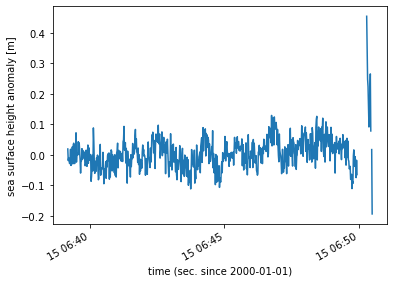

In [11]:
ds.ssha.plot()

## Verify the subsetting worked

Bounds used were: 

  'lat': '(-45.75:45)',
  'lon': '(-90:90)'

In [12]:
lat_max = ds.lat.max()
lat_min = ds.lat.min()

lon_min = ds.lon.min()
lon_max = ds.lon.max()

lon_min = (ds.lon.min() + 180) % 360 - 180
lon_max = (ds.lon.max() + 180) % 360 - 180

print(lon_min)
print(lon_max)



if lat_max < 45 and lat_min > -45.75:
    print("Successful Latitude subsetting")
else:
    assert False


if lon_max < 90 and lon_min > -90:
    print("Successful Longitude subsetting")
else:
    assert False
    

<xarray.DataArray 'lon' ()>
array(-89.987954)
<xarray.DataArray 'lon' ()>
array(-71.373639)
Successful Latitude subsetting
Successful Longitude subsetting
